xd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [3]:
def normalize_sample(sample):
    d = sample
    minX = np.min(d[:,0])
    maxX = np.max(d[:,0])
    minY = np.min(d[:,1])
    maxY = np.max(d[:,1])
    d[:,0] = (d[:,0] - minX) / (maxX - minX)
    d[:,1] = (d[:,1] - minY) / (maxY - minY)   
    return d 

In [4]:
def preprocess_data(data):

    # Normalize the data
    data = normalize_sample(data)

    # Remove data points that are too close to each other
    data_points = [data[0,:]]
    for measurement in data[1:]:
        if np.linalg.norm(measurement[0:2] - data_points[-1][0:2]) > 0.05:
            data_points.append(measurement)

    data = normalize_sample(np.array(data_points))

    return data

In [5]:
def feature_extraction(data):

    features = []

    N = np.shape(data)[0]

    xy_dist_from_origin = [np.sum(data[i,0:2]**2)**0.5 for i in range(N)]
    features.append(np.max(xy_dist_from_origin)-np.min(xy_dist_from_origin)) # max-min distance from origin

    dist_end_to_start = np.linalg.norm(data[-1] - data[0])
    features.append(dist_end_to_start) # distance from end to start

    features.append(np.std(data[:,0], ddof=0)) # standard deviation of x
    features.append(np.std(data[:,1], ddof=0)) # standard deviation of y
    features.append(np.mean(data[:,0])) # average of x
    features.append(np.mean(data[:,1])) # average of y

    xy_dist_from_mean = [np.sum((data[i,0:2] - np.mean(data[i,0:2]))**2)**0.5 for i in range(N)]
    features.append(np.std(xy_dist_from_mean, ddof=0)) # deviation of distance from mean
    features.append(np.mean(xy_dist_from_mean)) # average distance from mean

    

    return features


In [150]:
def image_creation(stroke):
    # This function assumes that the stroke is already normalized
    D = 20
    M = np.zeros([D,D])
    for i,point in enumerate(stroke[1:,0:2]):
        x0, y0 = stroke[i,0:2]
        x1, y1 = point
        x0 = int(x0*(D-1))
        y0 = int(y0*(D-1))
        x1 = int(x1*(D-1))
        y1 = int(y1*(D-1))

        dist = int(2*np.linalg.norm([x1-x0, y1-y0]))
        xspan = np.linspace(x0, x1, dist)
        yspan = np.linspace(y0, y1, dist)
        for i in range(dist):
            M[int(xspan[i]),int(yspan[i])] = 1
    return np.flipud(M.T)

Number 1


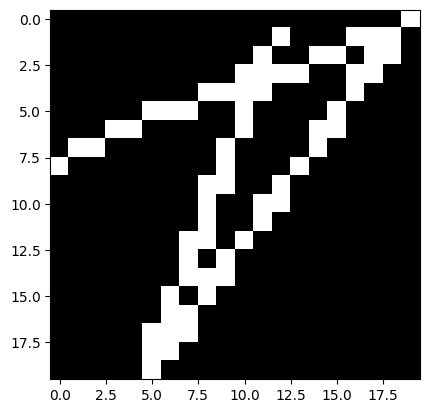

In [158]:
# Test data point
num = np.random.randint(0, 10)
print("Number", num)
sample = np.random.randint(1, 101)
fname = f'data/stroke_{num}_{str(0)*(4-len(str(sample))) + str(sample)}.csv'

data = pd.read_csv(fname).to_numpy()
data = preprocess_data(data)
M = image_creation(data)
plt.imshow(M, cmap='gray')

In [ ]:
data_file = open('data.csv', 'w')
for num in range(0, 10):
    for sample in range(1,101):
        fname = f'data/stroke_{num}_{str(0)*(4-len(str(sample))) + str(sample)}.csv'
        data = pd.read_csv(fname).to_numpy()
        data = preprocess_data(data)
        M = image_creation(data)

        features = np.ravel(M)
        # for f in feature_extraction(data):
        #     features = np.append(features, f)
        for f in features:
            data_file.write(str(f) + ',')
        data_file.write(str(num) + '\n')
data_file.close()

In [9]:
fdata = pd.read_csv('data.csv', header=None).to_numpy()
np.random.shuffle(fdata)

train_size = int(0.7 * len(fdata))
validation_size = int(0.1 * len(fdata))
ftrain = fdata[:train_size]
fvalidation = fdata[train_size:train_size+validation_size]
ftest = fdata[train_size+validation_size:]

X_train = [np.reshape(ftrain[i,:-1], (16, 16)) for i in range(len(ftrain))]
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(ftrain[:,-1]).long()

X_validation = [np.reshape(fvalidation[i, :-1], (16, 16)) for i in range(len(fvalidation))]
X_validation = torch.tensor(X_validation).float()
y_validation = torch.tensor(fvalidation[:,-1]).long()
#print(np.shape(ftest[0:-1]))
X_test = [np.reshape(ftest[i,:-1], (16, 16)) for i in range(len(ftest))]
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(ftest[:,-1]).long()

ValueError: cannot reshape array of size 625 into shape (16,16)

In [ ]:
class NumberClassifier(torch.nn.Module):
    def __init__(self):
        super(NumberClassifier, self).__init__()
        self.conv1 = torch.nn.Conv2d(16, 33, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(33, 66, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(8, 16)
        self.fc2 = torch.nn.Linear(16, 16)
        self.fc3 = torch.nn.Linear(16, 10)

    def forward(self, x):
        x = x.view(-1, 16, 16, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(-1, 8)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = NumberClassifier()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

J = []
V = []

best_validation_loss = 1000000
for epoch in range(10):

    model.train()
    running_loss = 0.0
    for i in range(len(X_train)):
        optimizer.zero_grad()
        outputs = model(X_train[i])
        loss = criterion(outputs, y_train[i])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(X_train)
    J.append(avg_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        voutputs = model(X_validation)
        vloss = criterion(voutputs, y_validation)
        validation_loss = vloss.item()
        V.append(validation_loss)
    
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(model.state_dict(), 'best_model.pth')

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, loss: {running_loss}, validation loss: {validation_loss}')

plt.figure()
plt.plot(J, label='Training loss')
plt.plot(V, label='Validation loss')
plt.legend()
plt.show()

ValueError: Expected input batch_size (132) to match target batch_size (0).

In [ ]:
model.load_state_dict(torch.load('best_model.pth', weights_only=False))

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    outputs = model(X_test)
    _, predicted = torch.max(outputs, dim=1)
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()
    print(f'Accuracy: {100 * correct / total}')

    # Confusion matrix
    confusion_matrix = np.zeros((10, 10))
    for i in range(len(predicted)):
        confusion_matrix[y_test[i], predicted[i]] += 1
    print(confusion_matrix)

Accuracy: 73.0
[[17.  0.  0.  0.  0.  1.  1.  0.  0.  0.]
 [ 1. 19.  1.  0.  0.  2.  1.  1.  0.  1.]
 [ 0.  0. 16.  3.  0.  1.  1.  0.  2.  0.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  4.  0.]
 [ 0.  0.  0.  0. 17.  0.  0.  0.  0.  1.]
 [ 6.  0.  1.  1.  0. 10.  2.  0.  0.  0.]
 [ 5.  0.  0.  0.  1.  3. 13.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0. 16.  0.  3.]
 [ 1.  0.  1.  2.  0.  3.  0.  0. 11.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0. 17.]]
